In [3]:
# Standard scientific imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.optimize as optimize
import scipy.integrate as integrate 

# Bayesian inference imports
import pymc3 as pm
import arviz as az
import theano.tensor as tt

# Visualization imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set_theme(style='ticks', context='notebook', font_scale=0.8);

%reload_ext watermark
%watermark -a "Mathieu Baltussen" -d -t -u -v -iv

Author: Mathieu Baltussen

Last updated: 2022-04-07 14:54:27

Python implementation: CPython
Python version       : 3.9.5
IPython version      : 7.28.0

numpy            : 1.20.3
pymc3            : 3.11.4
arviz            : 0.11.4
matplotlib       : 3.4.2
pandas           : 1.2.4
matplotlib_inline: 0.1.3
scipy            : 1.6.2
theano           : 1.1.2
sys              : 3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:32:32) 
[GCC 9.3.0]
seaborn          : 0.11.1



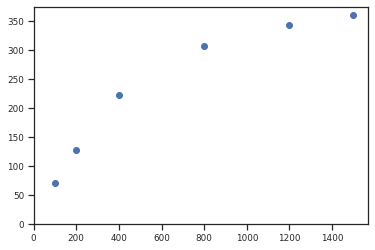

,S_in,P_obs,S_obs
0,100,70.849718,29.150282
1,200,127.156248,72.843752
2,400,223.281248,176.718752
3,800,307.084475,492.915525
4,1200,343.691064,856.308936
5,1500,359.961722,1140.038278


In [80]:
k_cat_real = 50
K_M_real = 150

E_conc = 1.0

kf = 0.125

noise = 5

def reactor(c, t, S_in):
    S, P = c
    v = k_cat_real * E_conc * S/(K_M_real + S)
    return [
        -v - kf*(S-S_in),
        v - kf*P
    ]

def generate_data(S_range, noise):
    steady_state_data = []

    for S_in in S_range:
        steady_state = integrate.odeint(reactor, [S_in, 0], np.linspace(0, 200, 100), args=(S_in,))[-1, 1]
        steady_state_data.append(steady_state)
    return np.array(steady_state_data) + np.random.normal(loc=0.0, scale=noise, size=len(S_range))

Substrate_range = np.array([100, 200, 400, 800, 1200, 1500])
data = generate_data(Substrate_range, noise=noise)

df_data = pd.DataFrame({'S_in': Substrate_range, 'P_obs': data, 'S_obs': Substrate_range - data})

plt.scatter(Substrate_range, data)
plt.xlim(0)
plt.ylim(0)
plt.show()
df_data

In [81]:
with pm.Model() as model:
    # Stating the priors
    k_cat = pm.Uniform("k_cat", 0, 100)
    K_M = pm.Uniform("K_M", 0, 500)
    sigma = pm.Exponential("sigma", 10)

    # We extract all data from the dataframe here so the likelihood is easier to write down
    S_in = df_data["S_in"].values
    P_obs = df_data["P_obs"].values
    S_obs = df_data["S_obs"].values

    # Inference of probabilistic model at steady-state conditions
    P = pm.Normal(
        "obs", 
        mu=k_cat * E_conc * S_obs / (kf * (K_M + S_obs)), 
        sigma=sigma, 
        observed=P_obs
    )

In [84]:
with model:
    idata = pm.sample(
        1000,
        tune=1000,
        cores=8,
        step=pm.NUTS(),
        return_inferencedata=True,
    )

Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, K_M, k_cat]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


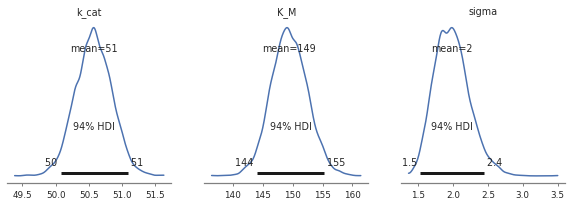

In [85]:
with model:
    az.plot_posterior(idata, figsize=(10,3))

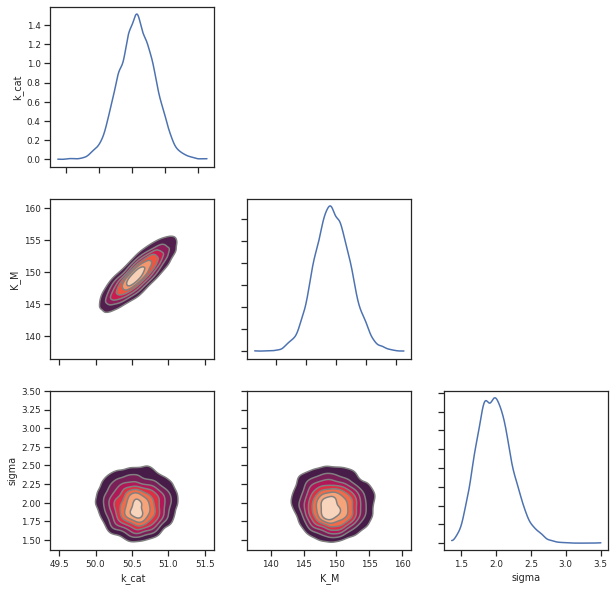

In [86]:
with model:
    az.plot_pair(idata, marginals=True, kind='kde', divergences=True, figsize=(10,10))

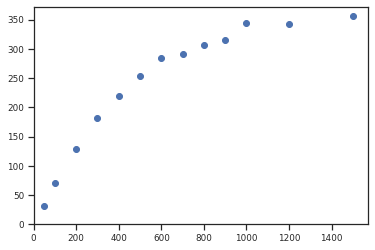

,S_in,P_obs,S_obs
0,50,31.597713,18.402287
1,100,70.296780,29.703220
2,200,128.965488,71.034512
3,300,181.753812,118.246188
4,400,219.276248,180.723752
5,500,253.349912,246.650088
6,600,283.573183,316.426817
7,700,291.013028,408.986972
8,800,305.909239,494.090761
9,900,315.605629,584.394371


In [92]:
Substrate_range = np.array([50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1500])
data = generate_data(Substrate_range, noise=5)

df_data = pd.DataFrame({'S_in': Substrate_range, 'P_obs': data, 'S_obs': Substrate_range - data})

plt.scatter(Substrate_range, data)
plt.xlim(0)
plt.ylim(0)
plt.show()
df_data

In [93]:
with pm.Model() as model:
    # Stating the priors
    k_cat = pm.Uniform("k_cat", 0, 100)
    K_M = pm.Uniform("K_M", 0, 500)
    sigma = pm.Exponential("sigma", 1)

    # We extract all data from the dataframe here so the likelihood is easier to write down
    S_in = df_data["S_in"].values
    P_obs = df_data["P_obs"].values
    S_obs = df_data["S_obs"].values

    # Inference of probabilistic model at steady-state conditions
    P = pm.Normal(
        "obs", 
        mu=k_cat * E_conc * S_obs / (kf * (K_M + S_obs)), 
        sigma=sigma, 
        observed=P_obs
    )

In [98]:
with model:
    idata = pm.sample(
        1000,
        tune=1000,
        cores=8,
        step=pm.NUTS(target_accept=0.85),
        return_inferencedata=True,
    )

Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, K_M, k_cat]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


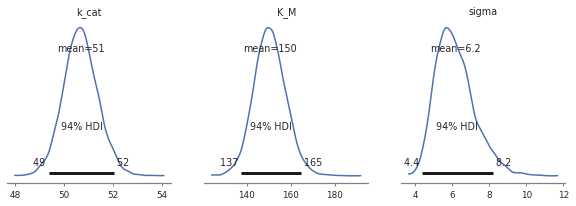

In [99]:
with model:
    az.plot_posterior(idata, figsize=(10,3))